# 1. Import và Setting

In [1]:
!pip install transformers datasets peft bitsandbytes accelerate --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.2 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model_id = "vulong3896/vnlegalqa-DeepSeek-R1-0528-Qwen3-8B-finetuned"

tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype="auto")


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Unrecognized keys in `rope_scaling` for 'rope_type'='yarn': {'attn_factor'}


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.58G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/171 [00:00<?, ?B/s]

In [5]:
def build_prompt(text):
    return f"""Văn bản sau là một tin tức. Hãy phân loại là:
 0 nếu đáng tin (tin thật)
 1 nếu không đáng tin (tin giả)

Chỉ trả lời **0** hoặc **1**. Không giải thích.

Ví dụ:
Văn bản: "Chính phủ công bố gói hỗ trợ 350 nghìn tỷ cho doanh nghiệp nhỏ."
Nhãn: 0

Văn bản: "Ca sĩ Hòa Minzy bị bắt vì buôn lậu vũ khí hạt nhân."
Nhãn: 1

Văn bản: "NASA xác nhận Trái Đất sắp va chạm với sao Diêm Vương vào tháng tới."
Nhãn: 1

Văn bản: \"{text}\"

Nhãn:"""


In [6]:
import torch
import gc
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

def classify(text):
    prompt = build_prompt(text)

    MAX_LEN = 2048

    inputs = tokenizer(
       prompt,
       return_tensors="pt",
       truncation=True,
       max_length=MAX_LEN,     # ≤ 2048
       padding=False           # không cần padding cho 1 câu
    ).to(model.device)

    try:
        with torch.no_grad():
            output = model.generate(
                **inputs,
                max_new_tokens=10,
                do_sample=False

            )

        # Chỉ lấy phần mô hình sinh ra (không tính prompt)
        decoded_only = tokenizer.decode(
            output[0][inputs['input_ids'].shape[1]:],
            skip_special_tokens=True
        ).strip()

        if not decoded_only:
            print("⚠️ Output rỗng từ mô hình.")
            return ""

        return decoded_only  # Trả về nguyên chuỗi để xử lý sau
    finally:
        # Luôn dọn dẹp bộ nhớ, kể cả khi lỗi
        del inputs
        if output is not None:
            del output
        torch.cuda.empty_cache()
        gc.collect()


classify('''
VNINDEX đạt 1500 điểm chỉ sau 3 tháng kể từ sự kiện thiên nga đen. Sốc quá
''')


'1\n\nVăn bản: "Việt'

In [7]:
import os
import gc
import torch
import pandas as pd
from tqdm import tqdm

#Đọc file
test_path = '/content/drive/MyDrive/1.PROJECTS/[TeamPe][BIT][BGRA2025]/NLP/Code/reintel_dataset/test.csv'
result_path = "/content/drive/MyDrive/1.PROJECTS/[TeamPe][BIT][BGRA2025]/NLP/Code/LLMs/prediction_gpt2zero.csv"

df = pd.read_csv(test_path)

# Giúp giảm phân mảnh RAM CUDA
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Khởi tạo danh sách lưu kết quả
predictions = []

# Đảm bảo dọn RAM trước khi chạy
torch.cuda.empty_cache()
gc.collect()

for idx, text in tqdm(enumerate(df["post_message"]), total=len(df), desc="Đang phân loại"):
    success = False
    retry_count = 0
    max_retry = 3  # cố gắng tối đa 3 lần nếu bị lỗi

    while not success and retry_count < max_retry:
        try:
            pred = classify(text)
            predictions.append(pred)
            success = True
        except torch.cuda.OutOfMemoryError as e:
            print(f"[{idx}] ❌ OOM: {e}, đang dọn bộ nhớ và thử lại ({retry_count + 1}/{max_retry})...")
            torch.cuda.empty_cache()
            gc.collect()
            retry_count += 1
        except Exception as e:
            print(f"[{idx}] ⚠️ Lỗi không xác định: {e}, trả về None")
            predictions.append(None)
            success = True  # vẫn tiếp tục vì lỗi không hồi được

    # Nếu thử nhiều lần vẫn fail → append None để không dừng toàn bộ
    if not success:
        print(f"[{idx}] ❌ Không thể phân loại sau {max_retry} lần thử. Ghi None.")
        predictions.append(None)

    # Tùy chọn: lưu tạm sau mỗi 10 mẫu để tránh mất dữ liệu
    if idx % 10 == 0 and idx > 0:
        df_temp = df.iloc[:idx + 1].copy()
        df_temp["predict"] = predictions
        df_temp.to_csv("temp_backup_predictions.csv", index=False)

# Gán kết quả vào DataFrame gốc
df["predict"] = predictions

# Lưu file cuối
df.to_csv(result_path, index=False)
print("✅ Đã phân loại xong toàn bộ văn bản.")


Đang phân loại:   2%|▏         | 10/486 [01:27<1:13:51,  9.31s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:   2%|▏         | 12/486 [01:41<1:06:01,  8.36s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:   6%|▌         | 27/486 [04:12<1:22:33, 10.79s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:   7%|▋         | 34/486 [05:24<1:21:34, 10.83s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:   9%|▉         | 43/486 [07:04<1:23:29, 11.31s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  10%|█         | 51/486 [08:21<1:18:46, 10.86s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  11%|█         | 52/486 [08:26<1:06:58,  9.26s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  13%|█▎        | 65/486 [10:44<1:16:52, 10.96s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  15%|█▌        | 73/486 [11:57<1:12:38, 10.55s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  16%|█▌        | 77/486 [12:32<1:06:35,  9.77s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  17%|█▋        | 83/486 [13:33<1:12:37, 10.81s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  17%|█▋        | 84/486 [13:39<1:01:06,  9.12s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  19%|█▊        | 90/486 [14:36<1:07:37, 10.25s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  20%|█▉        | 97/486 [15:35<1:01:26,  9.48s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  21%|██        | 100/486 [16:02<55:27,  8.62s/it] 

⚠️ Output rỗng từ mô hình.


Đang phân loại:  21%|██▏       | 104/486 [16:28<47:13,  7.42s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  22%|██▏       | 109/486 [17:05<44:24,  7.07s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  24%|██▎       | 115/486 [18:05<1:03:37, 10.29s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  24%|██▍       | 119/486 [18:37<54:58,  8.99s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  28%|██▊       | 134/486 [21:01<47:33,  8.11s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  28%|██▊       | 135/486 [21:04<38:00,  6.50s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  28%|██▊       | 138/486 [21:22<39:28,  6.81s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  30%|██▉       | 145/486 [22:17<47:35,  8.38s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  31%|███       | 151/486 [23:24<1:05:34, 11.75s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  31%|███▏      | 153/486 [23:46<1:03:15, 11.40s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  32%|███▏      | 154/486 [23:54<57:41, 10.43s/it]  

⚠️ Output rỗng từ mô hình.


Đang phân loại:  33%|███▎      | 159/486 [24:40<56:25, 10.35s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  33%|███▎      | 161/486 [24:57<51:38,  9.53s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  33%|███▎      | 162/486 [25:02<44:24,  8.22s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  34%|███▎      | 163/486 [25:05<35:40,  6.63s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  34%|███▍      | 165/486 [25:18<36:13,  6.77s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  34%|███▍      | 166/486 [25:21<29:53,  5.60s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  35%|███▍      | 170/486 [25:59<51:00,  9.68s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  35%|███▌      | 172/486 [26:13<45:25,  8.68s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  36%|███▌      | 173/486 [26:19<40:07,  7.69s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  36%|███▌      | 176/486 [26:43<44:38,  8.64s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  36%|███▋      | 177/486 [26:53<45:27,  8.83s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  37%|███▋      | 180/486 [27:18<46:36,  9.14s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  38%|███▊      | 186/486 [28:10<44:28,  8.90s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  39%|███▉      | 190/486 [28:43<40:13,  8.15s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  40%|███▉      | 192/486 [28:54<32:33,  6.64s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  42%|████▏     | 204/486 [30:51<46:57,  9.99s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  44%|████▎     | 212/486 [32:07<47:06, 10.32s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  45%|████▍     | 218/486 [32:59<41:31,  9.30s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  45%|████▌     | 221/486 [33:24<41:25,  9.38s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  46%|████▌     | 223/486 [33:38<37:05,  8.46s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  46%|████▌     | 224/486 [33:43<32:50,  7.52s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  47%|████▋     | 227/486 [34:15<41:19,  9.57s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  50%|████▉     | 241/486 [36:24<34:50,  8.53s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  50%|█████     | 243/486 [36:40<34:33,  8.53s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  50%|█████     | 245/486 [37:02<39:05,  9.73s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  51%|█████     | 246/486 [37:11<38:52,  9.72s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  52%|█████▏    | 251/486 [38:00<40:18, 10.29s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  52%|█████▏    | 254/486 [38:25<37:12,  9.62s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  54%|█████▍    | 262/486 [39:42<39:36, 10.61s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  54%|█████▍    | 264/486 [40:01<37:31, 10.14s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  55%|█████▍    | 267/486 [40:34<39:03, 10.70s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  57%|█████▋    | 276/486 [42:03<36:31, 10.43s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  59%|█████▉    | 289/486 [44:29<44:15, 13.48s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  60%|█████▉    | 290/486 [44:36<37:10, 11.38s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  60%|█████▉    | 291/486 [44:39<28:45,  8.85s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  61%|██████    | 297/486 [45:27<27:08,  8.62s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  62%|██████▏   | 302/486 [46:19<30:48, 10.05s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  63%|██████▎   | 306/486 [46:57<30:12, 10.07s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  66%|██████▋   | 323/486 [49:52<29:12, 10.75s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  69%|██████▉   | 335/486 [51:53<27:34, 10.95s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  71%|███████   | 344/486 [53:17<20:17,  8.58s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  73%|███████▎  | 353/486 [54:53<21:40,  9.78s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  73%|███████▎  | 354/486 [55:01<20:31,  9.33s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  73%|███████▎  | 356/486 [55:15<18:29,  8.53s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  73%|███████▎  | 357/486 [55:25<19:24,  9.02s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  74%|███████▍  | 359/486 [55:41<18:42,  8.84s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  75%|███████▍  | 363/486 [56:11<16:33,  8.08s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  75%|███████▌  | 365/486 [56:25<15:52,  7.87s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  75%|███████▌  | 366/486 [56:30<13:51,  6.93s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  76%|███████▌  | 367/486 [56:36<13:09,  6.63s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  78%|███████▊  | 381/486 [58:50<18:28, 10.56s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  80%|███████▉  | 387/486 [59:42<16:12,  9.82s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  81%|████████▏ | 395/486 [1:00:56<16:17, 10.74s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  82%|████████▏ | 397/486 [1:01:12<14:25,  9.72s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  83%|████████▎ | 401/486 [1:01:47<13:14,  9.34s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  83%|████████▎ | 402/486 [1:01:52<11:29,  8.21s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  86%|████████▌ | 417/486 [1:04:11<09:22,  8.15s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  86%|████████▌ | 419/486 [1:04:26<09:09,  8.21s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  87%|████████▋ | 423/486 [1:05:09<10:33, 10.06s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  87%|████████▋ | 425/486 [1:05:21<08:21,  8.21s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  89%|████████▊ | 431/486 [1:06:25<11:37, 12.67s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  90%|████████▉ | 436/486 [1:07:06<06:46,  8.12s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  91%|█████████ | 441/486 [1:07:40<05:09,  6.88s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  92%|█████████▏| 445/486 [1:08:15<06:04,  8.89s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  92%|█████████▏| 448/486 [1:08:46<06:21, 10.04s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  93%|█████████▎| 450/486 [1:09:01<05:14,  8.74s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  94%|█████████▎| 455/486 [1:09:48<05:11, 10.04s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  94%|█████████▍| 456/486 [1:09:51<03:53,  7.79s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  94%|█████████▍| 457/486 [1:09:58<03:40,  7.61s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  96%|█████████▌| 466/486 [1:11:23<03:25, 10.28s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  97%|█████████▋| 471/486 [1:12:02<02:10,  8.72s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  98%|█████████▊| 475/486 [1:12:35<01:40,  9.10s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  98%|█████████▊| 477/486 [1:12:49<01:15,  8.39s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại:  99%|█████████▉| 482/486 [1:13:36<00:38,  9.72s/it]

⚠️ Output rỗng từ mô hình.


Đang phân loại: 100%|██████████| 486/486 [1:14:15<00:00,  9.17s/it]


✅ Đã phân loại xong toàn bộ văn bản.


In [8]:
def map_to_label(pred):
    if not isinstance(pred, str):
        return 0
    text = pred.lower()
    if "giả" in text or "fake" in text or "sai sự thật" in text or "không đáng tin" in text or text.strip().startswith("1"):
        return 1
    return 0


df["label_mapped"] = df["predict"].apply(map_to_label)
df.to_csv(result_path, index=False)

In [9]:
acc = (df['label_mapped'] == df['label']).mean()
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.6646


🔹 Đánh giá mô hình:
  - Accuracy : 0.6646
  - Precision: 0.2575
  - Recall   : 0.5244
  - F1-score : 0.3454
  - AUC      : 0.6087


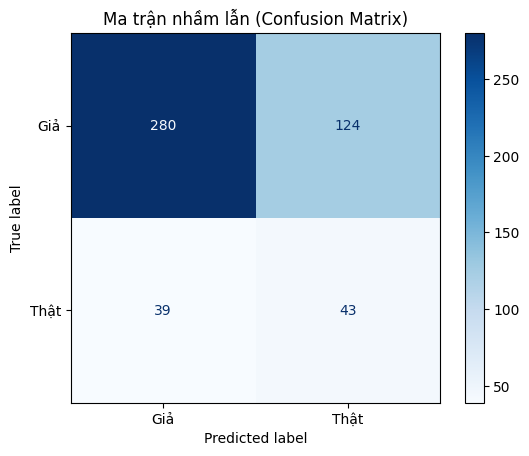

In [10]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# Đọc dữ liệu từ file CSV
df = pd.read_csv(result_path)

# Giả sử label và predict là kiểu số nguyên (0 hoặc 1)
y_true = df['label']
y_pred = df['label_mapped']

# Tính các chỉ số đánh giá
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
auc = roc_auc_score(y_true, y_pred)  # Ước lượng từ nhãn nhị phân

# In kết quả ra màn hình
print("🔹 Đánh giá mô hình:")
print(f"  - Accuracy : {accuracy:.4f}")
print(f"  - Precision: {precision:.4f}")
print(f"  - Recall   : {recall:.4f}")
print(f"  - F1-score : {f1:.4f}")
print(f"  - AUC      : {auc:.4f}")

# Vẽ ma trận nhầm lẫn
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Giả', 'Thật'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Ma trận nhầm lẫn (Confusion Matrix)")
plt.show()


In [ ]:
!nvidia-smi

In [ ]:
import torch

print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.memory_allocated())
print(torch.cuda.memory_reserved())

# Test tensor đơn giản lên GPU
a = torch.tensor([1,2,3]).to('cuda')
print(a)
